For Keplerian CM96 style disk we have:

$$y = -\frac{v_\phi}{c}\sin\phi\sin i$$

$$t = \frac{r}{c}\left(1-\cos\phi\sin i\right)$$

With $v_\phi/c = \sqrt{r_s/2r}$. Eliminating $\phi$ in the y and t equations above gives: 

$$r^3 + \left(\frac{r_s\cos^2i}{2y^2}\right)r^2 - \frac{r_sct}{y^2} + \frac{r_s(ct)^2}{2y^2} = 0$$

For any y and t we can find the corresponding value of $\phi$ using both the y and t equations above, and we can then also solve for r using the last equation. 

Substituting $r' = r/r_s$ and setting $G = M = c = 1$ gives:

$$\frac{2r' - y - t}{\sin i} - \cos\phi - \sqrt{1/2r'}\sin\phi = 0$$ 

$$8r'^3 +\left(\frac{4\cos^2i}{y^2}\right)r'^2 - \frac{2t}{y^2} + \frac{t^2}{2y^2} = 0$$

We should solve for $r'$ first from the cubic equation, then plug into the combined $y$ and $t$ equation to solve for $\phi$ at that $r'$.

3.366477303750272e10


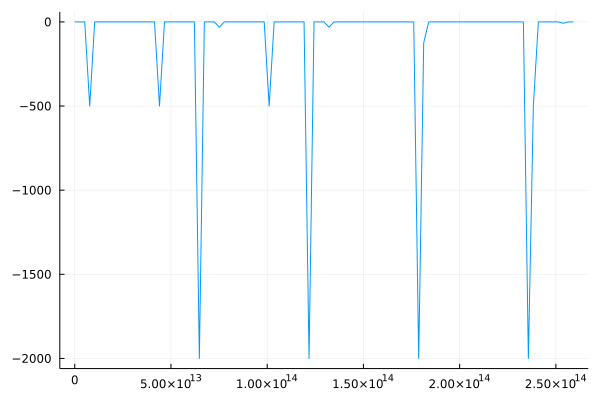

In [1]:
#testing some things
using Plots, Optim
# function r3(y::Float64,t::Float64,i::Float64,r)
#     return 8 .* r.^3 .+ (4*cos(i)^2/y^2).*r.^2 .- 2*t/y^2 .+ t^2/(2*y^2)
# end
rsCM96 = 1e16 #cm
c = 299792458 #SI, M from avg fit params
G = 6.6743e-11
M_CM96 = rsCM96/1e2*c^2/2/G/2e30
println(M_CM96)
M = M_CM96*2e30#7.8e7*2e30; 
rs = 2*G*M/c^2; days = 24*3600
#c = c/rs * days #now units of c are rs/day
#rs = 1 #trying something

function r3(y,t,i,r,rs,c)
    return r^3 + (rs*cos(i)^2/(2*y^2))*r^2 - rs*1/y^2 + rs/2*(1/y)^2
end


t = days
T = range(0,stop=10*days,length=101)
y = 0.01
i = 75/180*π
function getRoots(T,y,i,rs,c)
    r = range(-10e3*rs,stop=10e3*rs,length=1001)
    r0 = [1e3*rs]
    results = zeros(length(T))
    f(x,y,t,i,rs,c) = sqrt(r3(y,t,i,x[1],rs,c)^2) #so always +

    for i=1:length(T)
        t=T[i]
        res = optimize(r -> f(r,y,t,i,rs,c),r0)
        results[i] = res.minimizer[1]
    end
    return results
end
#plot(c.*t,log.(r3.(y,t,i,rs,rs,c)))
roots = getRoots(T,y,i,rs,c)
plot(c.*T,roots./rs,label="")

min r = [223.03627829530754, 3431.5972870556607]
val at min = [0.0, -3.022314549036573e23]
i = 1.3089969389957472
analytic eval = [7.162318492260297e36, 1.3755583386393242e42]
rs = 2.9644444444444446e11
analytic = [222.37940183154677, 12830.286451087019]
ϕ root = [0.10954635833977344, 2.6983907892664742] ([6.276543993896766, 154.6064037019441] deg)


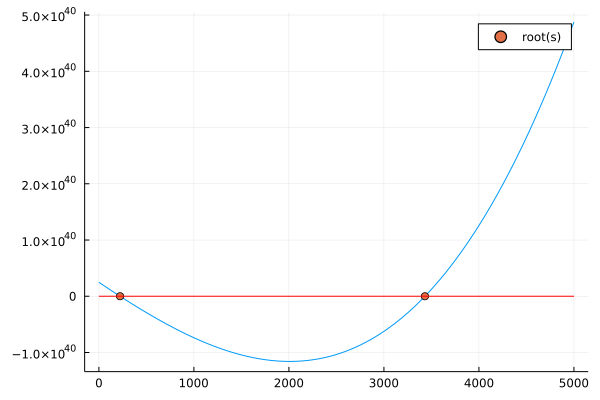

In [48]:
using Plots, Roots
c = 3e8 #SI, M from avg fit params
days = 24*3600.
M = 1e8*2e30
G = 6.67e-11
rs = 2*G*M/c^2
y=0.005
function r3(t,i,r,c,y)
    term1 = rs*cos(i)^2*r^2/2
    term2 = -rs*c*t*r
    term3 = rs*(c*t)^2/2
    #println("term1 = $term1; term2 = $term2; term3 = $term3")
    return r^3*y^2 + term1 + term2 + term3
end

t = 5*days
i = 75/180*π
r = range(0*rs,stop=5e3*rs,length=101)
plot(r./rs,r3.(t,i,r,c,y),label="")
f(x,t,i,c,y) = r3(t,i,x[1],c,y)^2 #so always +
r0 = [1e3*rs]
#res = optimize(r -> f(r,t,i,c,y),r0)
res = find_zeros(r -> r3(t,i,r,c,y),0,15e3*rs)
res./rs

println("min r = $(res./rs)")
println("val at min = ",r3.(t,i,res,c,y))
analytic = [c*t/(1+sin(i)),c*t/(1-sin(i))]
println("i = $i")
println("analytic eval = $(r3.(t,i,analytic,c,y))")
println("rs = $rs")
println("analytic = $(analytic./rs)")
ϕroot = atan.(y.*sqrt.(2 .*res./rs),(c*t./res .-1))
println("ϕ root = $ϕroot ($(ϕroot/π*180) deg)")
scatter!(res./rs,r3.(t,i,res,c,y),label="root(s)")
plot!(r./rs,zeros(length(r)),label="",color=:red)
#scatter!([analytic]./rs,[r2(t,i,analytic,c)],label="analytic + r root")
#plot!(xlims=(-2e13,2e13),ylims=(-1e14,1e15))

In [122]:
function getR(y,t,i,c)
    res = find_zeros(r -> r3(t,i,r,c,y),0,15e3*rs)
    return maximum(res) #want the + solution
end

function getϕ(y,t,i,r,c,rs)
    ϕroot = atan(-y*sqrt(2*r/rs),(1-c*t/r))
    return ϕroot
end
function J(r,ϕ,i,c)
    j = -sqrt(1/(2*r))/c*sin(i)*((1-3*cos(ϕ)^2)/2*sin(i)+cos(ϕ)) #just CM96 jacobian (i.e. Waters appendix) -- need to re-do with extra terms? 
    return abs(j)
end

function dvldl(r,i,ϕ,f1::Float64=1.,f2::Float64=1.,f3::Float64=0.,f4::Float64=0.) #r in terms of r_s, to convert to physical units multiply answer by c/r_s
    sini = sin(i); cosi = cos(i)
    pre = sqrt.(1 ./(2 .*r.^3)); cosϕ = cos.(ϕ); sinϕ = sin.(ϕ)
    #term1 = ((3*sini^2*√2) .* (cosϕ.^2))
    #term2 = ((3*sini^2/2) .* (cosϕ .* sinϕ)) #disk only
    term12 = (3*sini^2).*(cosϕ) .* (√2*f1 .* cosϕ .+ f2/2 .* sinϕ)
    term3 = ((-f3*3*sini*cosi) .* cosϕ)
    term4 = √2*f4*cosi^2 .*ones(size(pre)) #otherwise term4 does not have right shape
    #dvl =  (pre) .* (term1 .+ term2 .+ term3 .+ term4) #new terms approach
    dvl = pre.*(term12 .+ term3 .+ term4)
    return dvl
end

function I(r,i,ϕ,A0,dvldl,τ,γ,f1=1.,f2=1.,f3=0.,f4=0.) #code units, multiply by 1/(c*rs^2) to get to physical
    A = A0*r^γ
    return A/(4π*r^2) * abs(dvldl(r,i,ϕ,f1,f2,f3,f4))*(1 - exp(-τ))
end

function dvldl2(r,rs,i,ϕ,c)
    return 3*sqrt(rs/(2*r))*c/r*sin(i)^2*cos(ϕ)*(sqrt(2)*cos(ϕ)+sin(ϕ)/2)
end

function I2(A0,c,dvldl)
    return A0/(4*π*c)*abs(dvldl)
end

function Ψ(y,t,i,c,rs;A0=1.,γ=1.,τ=10.,f1=1.,f2=1.,f3=0.,f4=0.,getVals=true,r=nothing,ϕ=nothing)
    if getVals == true
        r = getR(y,t,i,c)
        #println("r = $(r/rs)")
        ϕ = getϕ(y,t,i,r,c,rs) #+ π/2
    end
    #println("ϕ = $ϕ")
    j = J(r/rs,ϕ,i,c) #this r needs to be in terms of rs
    dvl = dvldl2(r,rs,i,ϕ,c)
    i = I2(A0,c,dvl)
    #i = I(r/rs,i,ϕ,A0,dvldl,τ,γ,f1,f2,f3,f4)#*(rs^-3) #code -> physical: (c/r_s * 1/(c*rs^2))
    return i/j
end
Ψ(y,t,i,c,rs)

3.2031468986709757e-7

In [65]:
Y = range(-0.02,stop=0.02,length=256)
T = range(0,stop=20,length=128)
z = zeros(length(Y),length(T)); ϕ = zeros(length(Y),length(T))
for y=1:length(Y)
    for t=1:length(T)
        try
            z[y,t],ϕ[y,t] = Ψ(Y[y],T[t]*days,i,c,rs)
        catch
            z[y,t] = 0.
        end
    end
end

In [76]:
vϕ_c = -Y ./ (sin.(ϕ).*sin(i))
vϕArr = zeros(length(Y))
for y=1:length(Y)
    s=0;
    for t=1:length(T)
        if isnan(vϕ_c[y,t]) == false && abs(vϕ_c[y,t]) != Inf
            s += vϕ_c[y,t]
        end
    end
    vϕArr[y] = s/length(T)
end
vϕArr

256-element Vector{Float64}:
 0.01894490819894437
 0.019170734512612118
 0.01922339880151404
 0.019439879775406
 0.019652130958850732
 0.019695112351783565
 0.01989788301758127
 0.020095859355179352
 0.020288985089226805
 0.020477189752771515
 0.020660396528139575
 0.020838566735429467
 0.021011745259139274
 ⋮
 0.020838566735429467
 0.020660396528139575
 0.020477189752771515
 0.020288985089226805
 0.020095859355179352
 0.01989788301758127
 0.019695112351783565
 0.019652130958850732
 0.019439879775406
 0.01922339880151404
 0.019170734512612118
 0.01894490819894437

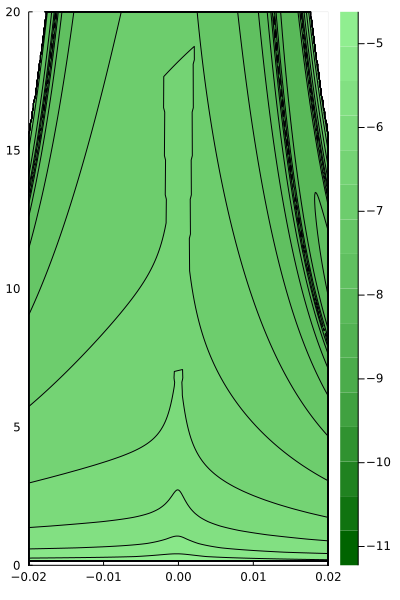

┌ Warning: GR: filled contour only supported with black contour lines
└ @ Plots /home/kirk/.julia/packages/Plots/OeNV1/src/backends/gr.jl:2020


In [79]:
contour(Y,T,log10.(z)',fill=(true,cgrad(:greens,[0.,0.3,1.0],rev=true)),size=(400,600))

In [233]:
#trying to use r,ϕ from disk to calculate y,t

include("DiskWind/src/functions.jl")
α,β,rArr,nuArr,ϕArr,sini,cosi,dA,rMin,rMax = setup(75.,2048,2048,1e3,15.,1.,:polar,:log)
# USING MY/CM96/CODE ϕ #
# yArr = nuArr .- 1 #if using code units, this works fine, but out of phase by π/2
# tArr = rArr .* (rs/c/days) .* (1 .- sin.(ϕArr).*sini) # this t is matches y above
# USING WATERS ϕ

M = 0.8e8*2e30 #matching plot by eye
rs = 2*G*M/c^2
ϕ′ = ϕArr .+ π/2 #waters phi
tArr = rArr .* (rs/c/days) .* (1 .- cos.(ϕ′).*sini)
yArr = -sqrt.(1 ./ (2 .*rArr)).*sin.(ϕ′).*sini

dvldlCode = 3 .* sqrt.(1 ./ (2 .*rArr)) .* c ./ (rs.*rArr) .* (sini)^2 .* cos.(ϕ′) .* (√2 .* cos.(ϕ′) .+ sin.(ϕ′)./2)
JCode = -sqrt.(1 ./ (2 .*rArr))./c .* sini .* ((1 .- 3 .* (cos.(ϕ′)).^2)./2 .* sini .+ cos.(ϕ′))
A0 = 0.3e5
ICode = A0/(4*π*c) .* abs.(dvldlCode)
ΨCode = ICode ./ abs.(JCode) #./ ((rArr.*rs).^2)
#BOTH PRODUCE SAME PLOT
p=scatter(yArr[rArr .> rMin].* (c/1e6),tArr[rArr .> rMin],label="",markerz=log10.(ΨCode[rArr .> rMin]),markerstrokewidth=0.,markersize=1.,
    clims=(-3,2),ylims=(0,20),size=(550,600),markercolor=cgrad(:greens,[0.,0.3,1.0]))
png(p,"tmp.png")
maximum(nuArr[rArr .> rMin]),maximum(nuArr)

(1.032486263851039, 1.0638859544617565)

In [231]:
#new process
#1 bin along y,t
#at each y,t bin calc average Ψ
#contour 1D y,t with 2D Ψ

yMax = maximum(yArr); yMin = minimum(yArr)
tMax = maximum(tArr); tMin = minimum(tArr)
yBinned = range(yMin,stop=yMax,length=256); tBinned = range(tMin,stop=21,length=512)
Δy = yBinned[2]-yBinned[1]; Δt = tBinned[2]-tBinned[1]
ΨBinned = zeros(length(yBinned),length(tBinned))
for i=1:length(yBinned)
    print("$(round(i/length(yBinned)*100,sigdigits=3)) % complete \r")
    yMinTmp = yBinned[i]-Δy/2; yMaxTmp = yBinned[i] + Δy/2
    yMask = yArr[(yArr .> yMinTmp) .& (yArr .< yMaxTmp) .& (rArr .> rMin)]
    for j=1:length(tBinned)
        tMinTmp = tBinned[j]-Δt/2; tMaxTmp = tBinned[j] + Δt/2
        mask = (yArr .> yMinTmp) .& (yArr .< yMaxTmp) .& (tArr .> tMinTmp) .& (tArr .< tMaxTmp) .& (rArr .> rMin)
        s = sum(ΨCode[mask])
        if s > 0
            ΨBinned[i,j] = s/length(ΨCode[mask])
        end
    end
end    

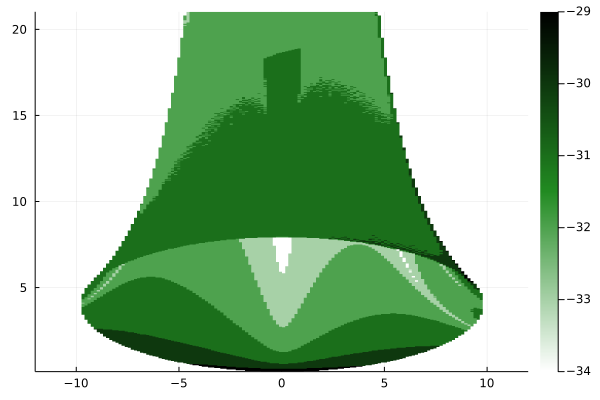

In [232]:
heatmap(yBinned.*(c/1e6),tBinned,floor.(log10.(ΨBinned)'),fill=(true,cgrad([:white,:forestgreen,:black],[0.,-2.5,-5.0])),xlims=(-12,12),levels=reverse([-0.4*i for i=0:11]))

120025.001
min r = [16.932398650780375]
val at min = [2.170971129089594e-5]
last term = 5.617219867105111e33


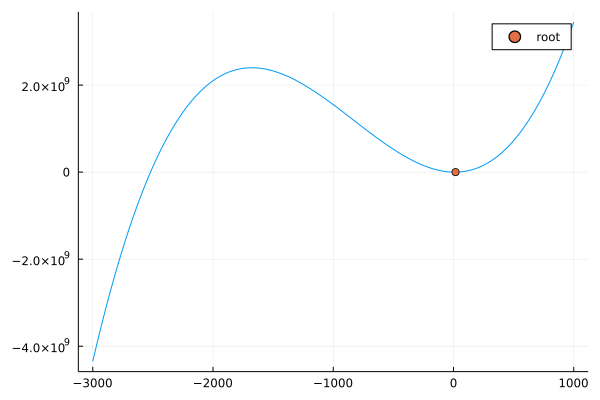

In [27]:
#TESTING SPACE BELOW MAY NOT WORK / DON'T USE WITHOUT CHECKING THOROUGHLY

function r3(y,t,i,r,rs,c)
    return r^3 + (rs*cos(i)^2/(2*y^2))*r^2 - rs*c*t/y^2 + rs/2*(c*t/y)^2
end
function r3(y,t,i,r,rs,c)
    return r^3 + (cos(i)^2/(2*y^2))*r^2 - t/y^2*r + t^2/(2*y^2)
end
r = range(-3e3,stop=1e3,length=1000)
y = 0.01; t = 5; i = 45/180*π
f(x,y,t,i,rs,c) = r3(y,t,i,x[1],rs,c)^2 #so always +
r0 = [1e3]
println(r3(y,t,i,0.1,rs,c))
res = optimize(r -> f(r,y,t,i,rs,c),r0)
plot(r,r3.(y,t,i,r,rs,c),label="")
println("min r = $(res.minimizer)")
println("val at min = ",r3.(y,t,i,res.minimizer,rs,c))
println("last term = ",(rs/2*(c*t)/(y))^2)
plot(r,r3.(y,t,i,r,rs,c),label="")
scatter!(res.minimizer,r3.(y,t,i,res.minimizer,rs,c),label="root")

In [15]:
M = 1e6*2e30
rs = 2*G*M/c^2
t = days
a_act = rs*cos(i)^2/(2*y^2); b_act = rs*c*t/y^2; c_act = rs/2*(c*t/y)^2
norm_act = a_act + b_act + c_act
a_plot = a_act/norm_act; b_plot = b_act/norm_act; c_plot = c_act/norm_act
rsCM96 = 1e8 #cm
M_CM96 = rsCM96/1e2*c^2/2/G/2e30

3.7457111607209757e-17

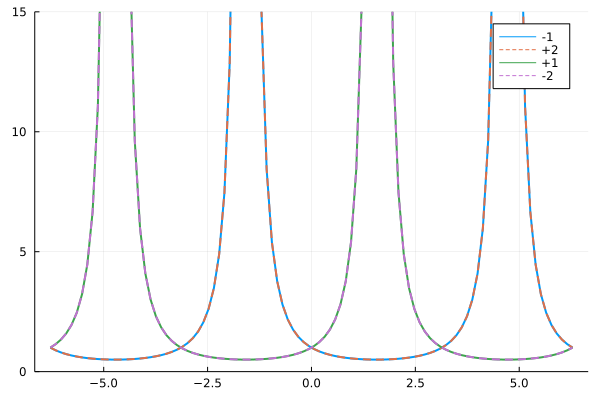

In [176]:
r1(x) = (1 - sin(x))/(cos(x)^2)
r2(x) = 1/(1+sin(x))
r3(x) = (1 + sin(x))/(cos(x)^2)
r4(x) = 1/(1-sin(x))
x = range(-2π,stop=2π,length=100)
plot(ylims=(0,15))
plot!(x,r1.(x),label="-1",lw=2)
plot!(x,r2.(x),label="+2",lw=2,linestyle=:dash)
plot!(x,r3.(x),label="+1",lw=2)
plot!(x,r4.(x),label="-2",lw=2,linestyle=:dash)

zero-point = 0.11523437500000001; val = -0.00042522102594376443
dist to inflection = 0.4485677083333333


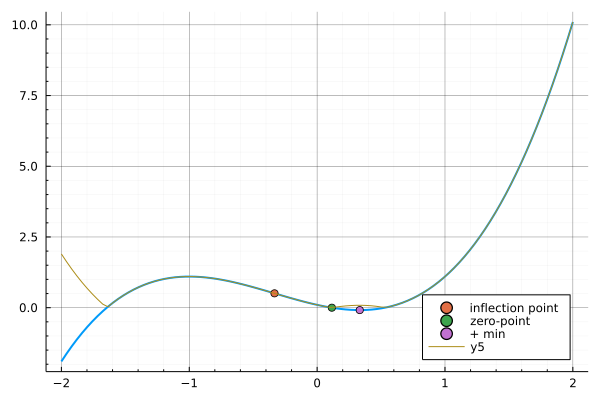

In [95]:
x3test(x,a,b,c) = x^3 + a*x^2 - b*x + c
a = 1; b = 1; c = 0.1
x = range(-2,stop=2,length=100)
x0 = [0.]
res = optimize(x -> x3test(x[1],a,b,c)^2,x0)
println("zero-point = ",res.minimizer[1],"; val = ",x3test(res.minimizer[1],a,b,c))
println("dist to inflection = ",res.minimizer[1]-(-a/3))
plot(x,x3test.(x,a,b,c),label="",lw=2,minorgrid=true,gridalpha=0.5)
scatter!([-a/3],x3test.([-a/3],a,b,c),label="inflection point")
scatter!(res.minimizer,x3test.(res.minimizer,a,b,c),label="zero-point",legend=:bottomright)
scatter!([-a/3 + sqrt(4*a^2 + 12*b)/6],x3test.([-a/3 + sqrt(4*a^2 + 12*b)/6],a,b,c),label="+ min")
plot!(x,sqrt.(x3test.(x,a,b,c).^2))

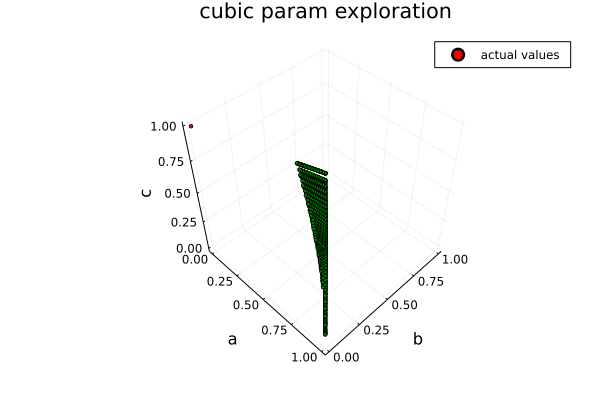

In [16]:
rootVal(a,b,c) = 1/27*(2*a^3 - 2*(a^2 + 3*b)^(3/2) + 9*a*b + 27*c)
a = range(0,stop=1,length=20); b = range(0,stop=1,length=20); c = range(0,stop=0.5,length=20)
results = zeros(length(a),length(b),length(c))
p = plot3d(title="cubic param exploration",xlabel="a",ylabel="b",zlabel="c")
for i = 1:length(a)
    for j = 1:length(b)
        for k = 1:length(c)
            norm = sum([a[i],b[j],c[k]])
            color = rootVal(a[i],b[j],c[k]) < 0 ? :green : :red
            alpha = rootVal(a[i],b[j],c[k]) < 0 ? 1. : 0.0
            p = scatter!([a[i]]./norm,[b[j]]./norm,[c[k]]./norm,c = color,alpha=alpha,label="",markeredgestrokewidth=0,markersize=2)
        end
    end
end
scatter!([a_plot],[b_plot],[c_plot],color=:red,label="actual values",markeredgestrokewidth=0,markersize=2)
p = plot!(camera=(45,45))


100-element Vector{Float64}:
 0.0
 0.1111111111111111
 0.2222222222222222
 0.3333333333333333
 0.4444444444444444
 0.5555555555555556
 0.6666666666666666
 0.7777777777777778
 0.8888888888888888
 1.0
 0.0
 0.1111111111111111
 0.2222222222222222
 ⋮
 0.8888888888888888
 1.0
 0.0
 0.1111111111111111
 0.2222222222222222
 0.3333333333333333
 0.4444444444444444
 0.5555555555555556
 0.6666666666666666
 0.7777777777777778
 0.8888888888888888
 1.0

In [ ]:
function r3roots(x,y,r,i) #x = r, y = y, r = rs, i = cos^2i
    i = cos(i)^2
    pre = (6*2^(1/3)*y^2)^-1
    term1 = (-108*c^2*r*y^4-36*c*i*r^2*y^2 - 2*i^3*r^3)^2
    term2 = 4*(-12*c*r*y^2 - i^2*r^2)^3
    sqrt1 = sqrt(term1+term2)
    term3 = -108*c^2*r*y^4-36*c*i*r^2*y^2-2*i^3*r^3
    

In [62]:
function getR(y,t,i,r0=0.)
    function r3(y::Float64,t::Float64,i::Float64,r)
        return r.^3 .+ (cos(i)^2/(2*y^2)).*r.^2 .- t/y^2 .*r .+ t^2/(2*y^2)
    end
    r0 = [r0]
    f(x,y,t,i) = r3(y,t,i,x[1])^2 #so always +
    res = optimize(r -> f(r,y,t,i),r0)
    return res.minimizer[1]
end

function getϕ(y,t,i,r,ϕ0 = 45.)
    function ϕZero(y,t,i,r,ϕ)
        return -sqrt(1/(2*r))*sin(ϕ)*sin(i) + r - cos(ϕ)*sin(i) - y - t
    end
    ϕ0 = [ϕ0/180*π]
    f(x,y,t,i,r) = ϕZero(y,t,i,r,x[1])^2
    res = optimize(ϕ -> f(ϕ,y,t,i,r),ϕ0)
    return res.minimizer[1]
end

getϕ (generic function with 2 methods)

In [63]:
y=0.01;t=5.;i=75. /180*π
r = getR(y,t,i)
ϕ = getϕ(y,t,i,r)

3.558773218543566

In [50]:
function J(r,ϕ,i)
    j = -sqrt(1/(2*r))*sin(i)*((1-3*cos(ϕ)^2)/2*sin(i)+cos(ϕ)) #just CM96 jacobian (i.e. Waters appendix) -- need to re-do with extra terms? 
    return abs(j)
end
J(r,ϕ,i)

0.8472560233431785

In [51]:
function dvldl(r,i,ϕ,f1::Float64=1.,f2::Float64=1.,f3::Float64=0.,f4::Float64=0.)
    sini = sin(i); cosi = cos(i)
    pre = sqrt.(1 ./(2 .*r.^3)); cosϕ = cos.(ϕ); sinϕ = sin.(ϕ)
    #term1 = ((3*sini^2*√2) .* (cosϕ.^2))
    #term2 = ((3*sini^2/2) .* (cosϕ .* sinϕ)) #disk only
    term12 = (3*sini^2).*(cosϕ) .* (√2*f1 .* cosϕ .+ f2/2 .* sinϕ)
    term3 = ((-f3*3*sini*cosi) .* cosϕ)
    term4 = √2*f4*cosi^2 .*ones(size(pre)) #otherwise term4 does not have right shape
    #dvl =  (pre) .* (term1 .+ term2 .+ term3 .+ term4) #new terms approach
    dvl = pre.*(term12 .+ term3 .+ term4)
    return dvl
end

function I(r,i,ϕ,A0,dvldl,τ,γ,f1=1.,f2=1.,f3=0.,f4=0.)
    A = A0*r^γ
    return A/(4π*r^2) * abs(dvldl(r,i,ϕ,f1,f2,f3,f4))*(1 - exp(-τ))
end

function Ψ(y,t,i;A0=1.,γ=1.,τ=10.,f1=1.,f2=1.,f3=0.,f4=0.)
    r = getR(y,t,i)
    ϕ = getϕ(y,t,i,r) + π/2
    j = J(r,ϕ,i)
    i = I(r,i,ϕ,A0,dvldl,τ,γ,f1,f2,f3,f4)
    return i/j
end
Ψ(y,t,i)

0.03844718887867839

In [64]:
Y = range(-10,stop=10,length=101)./100
T = range(0,stop=20,length=101)
z = zeros(length(Y),length(T))
for y=1:length(Y)
    for t=1:length(T)
        try
            z[y,t] = Ψ(Y[y],T[t],i)
        catch
            z[y,t] = 0.
        end
    end
end

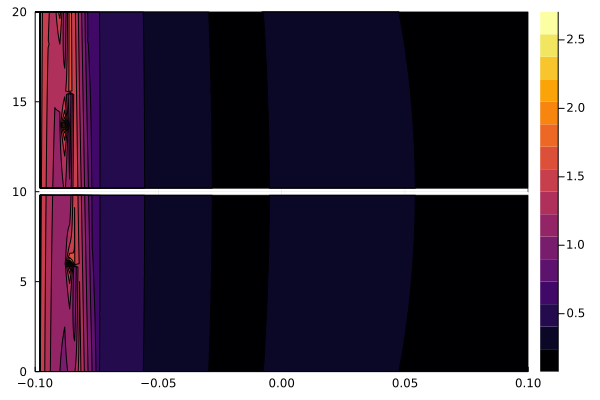

In [65]:
contour(Y,T,z.^(1/6),fill=true)

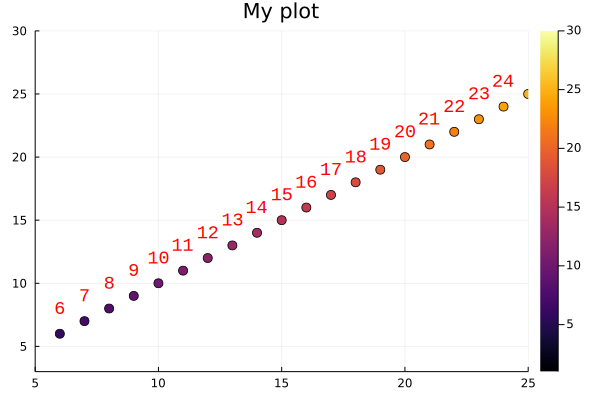

In [78]:
x = (1:1:30); xlims=(5,25)
p = plot(x, x, zcolor = x, seriestype = :scatter, title = "My plot", 
xlim=xlims, ylim=(3, 30), markersize=5, label = "")

for i=1:length(x)
    if x[i]>xlims[1] && x[i]<xlims[2]
        p = annotate!(x[i],x[i]+2,text("$(x[i])",:Courier,10,:red))
    end
end
display(p)

In [4]:
function cubeRoots(r,y,c,i) #x = r, r = rs, i = (cosi)^2, c = c*t, y ~ v/c
    pre1 = 1/(6*2^(1/3)*y^2)
    println("1    ",(-108*c^2*r*y^4 - 36*c*i*r^2*y^2 - 2*i^3*r^3)^2)
    println("2    ",4*(-12*c*r*y^2 - i^2*r^2)^3)
    return 0
    sqrt1 = sqrt((-108*c^2*r*y^4 - 36*c*i*r^2*y^2 - 2*i^3*r^3)^2 + 4*(-12*c*r*y^2 - i^2*r^2)^3)
    term3 = -108*c^2*r*y^4 - 36*c*i*r^2*y^2 - 2*i^3*r^3
    third1 = pre1*(sqrt1 + term3)^(1/3)
    
    pre2num = -12*c*r*y^2 - i^2*r^2
    pre2den = 3*2^(2/3)*y^2
    sqrt2 = sqrt1
    term8 = term3
    third2 = -pre2num/(pre2den*(sqrt2+term8)^(1/3))
    finalterm = -i*r/(6*y^2)
    
    return third1 + third2 + finalterm
end

cubeRoots(rs,0.01,5*days,cos(75/180*π)^2)

1    5.59150707448583e61
2    -5.591507074486802e61


0

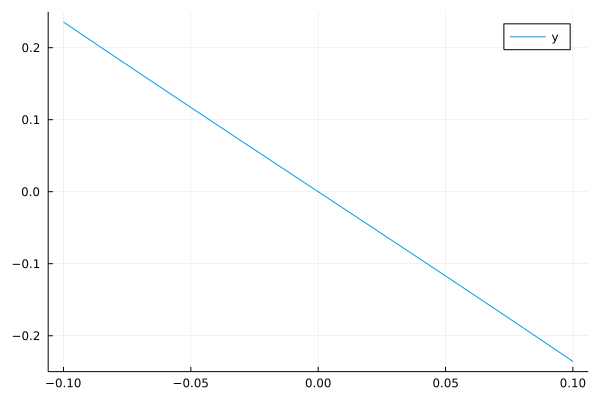

In [73]:
ϕy(y,i,r) = asin(-y/sin(i)*sqrt(2*r))
ϕt(t,i,r) = acos((1-t/r)/sin(i))
x=range(-0.1,stop=0.1,length=101)
plot(x,ϕy.(x,i,r),label="y")
#plot!(x,ϕt.(x,i,r),label="t")

In [110]:
1/(2*0.01^2)

5000.0